In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
sns.set(style="darkgrid")
pd.set_option('display.width', 200)
pd.set_option('precision', 4)
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 200)
pd.set_option('display.notebook_repr_html', True)

In [3]:
def display_all(df):
    with pd.option_context("display.max_rows",1000):
        with pd.option_context("display.max_columns",1000):
            display(df)

In [4]:
def get_nullframe(dataset):
    null_sum = dataset.isnull().sum()[dataset.isnull().sum()>0] 
    return pd.DataFrame({'feature':null_sum.index,'count':null_sum.values,
                          'null_percent':(null_sum.values/dataset.shape[0])*100}).sort_values(by=['count'],ascending=False)

In [5]:
from sklearn import metrics
from sklearn.metrics import roc_curve
def measure_performance(X, y, clf, show_accuracy=True,show_classification_report=True,
                        show_confusion_matrix=True, show_r2_score=False):
    y_pred = clf.predict(X) 
    if show_accuracy:
        print ("Accuracy:{0:.3f}".format( metrics.accuracy_score(y, y_pred)) )
    if show_classification_report:
        print ("Classification report")
        print (metrics.classification_report(y, y_pred))
    if show_confusion_matrix:
        print("Confusion matrix") 
        print(metrics.confusion_matrix(y, y_pred),)
    if show_r2_score:
        print ("Coefficient of determination:{0:.3f}"
               .format( metrics.r2_score(y, y_pred)))
    return y_pred

from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
def plot_learning_curve(train_sizes, train_scores, validation_scores):
    plt.figure()
    plt.title("Learning Curve")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(train_sizes, validation_scores_mean, 'o-', color="g" ,label="Cross-validation score")
    plt.ylim(max(-3, validation_scores_mean.min() - .1), train_scores_mean.max() + .1)
    plt.legend(loc="best")
    plt.show()

from sklearn.model_selection import validation_curve
def plot_validation_curve(parameter_values, train_scores, validation_scores):
    plt.figure()
    plt.title("Validation Curve")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)

    plt.fill_between(parameter_values, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(parameter_values, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
    plt.plot(parameter_values, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(parameter_values, validation_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.ylim(validation_scores_mean.min() - .1, train_scores_mean.max() + .1)
    plt.legend(loc="best")
    plt.show()

def plot_roc(X_val,y_val,model):
    fpr, tpr, thresholds = roc_curve(y_val, model.predict_proba(X_val)[:, 1])
    plt.figure()
    plt.plot(fpr, tpr, label="ROC Curve")
    plt.xlabel("FPR")
    plt.ylabel("TPR (recall)")
    plt.title("roc_curve");
    # find threshold closest to zero:
    close_zero = np.argmin(np.abs(thresholds))
    plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
         label="threshold zero", fillstyle="none", c='k', mew=2)
    plt.legend(loc=4)
    plt.show()

def test_classifier(model,X,y,cv):
    clf = model.fit(X,y.values.ravel())
    result = clf.score(X,y.values)
    print ("Accuracy: {0:.3f}".format(result*100.0))

    train_sizes, train_scores, validation_scores = learning_curve(clf, X,y.values.ravel(),cv=cv)
    plot_learning_curve(train_sizes, train_scores, validation_scores)
    return clf,result

In [6]:
train=pd.read_csv("train_u6lujuX_CVtuZ9i.csv")
test=pd.read_csv("test_Y3wMUE5_7gLdaTN.csv")

In [7]:
continuous_ds = train.select_dtypes(np.number)
continuous_columns = continuous_ds.columns.values.tolist()
continuous_columns

['ApplicantIncome',
 'CoapplicantIncome',
 'LoanAmount',
 'Loan_Amount_Term',
 'Credit_History']

In [8]:
categorical_ds = train.select_dtypes("object")
categorical_columns = categorical_ds.columns.values.tolist()
ordinal_columns =['Dependents','Education','Property_Area']
categorical_columns = [ column for column in categorical_columns if column not in ordinal_columns ]
categorical_columns.remove('Loan_ID')

In [9]:
train_null =get_nullframe(train)
train_null

,feature,count,null_percent
6,Credit_History,50,8.1433
3,Self_Employed,32,5.2117
4,LoanAmount,22,3.5831
2,Dependents,15,2.4430
5,Loan_Amount_Term,14,2.2801
0,Gender,13,2.1173
1,Married,3,0.4886


In [10]:
test_null =get_nullframe(test)
test_null

,feature,count,null_percent
5,Credit_History,29,7.9019
2,Self_Employed,23,6.2670
0,Gender,11,2.9973
1,Dependents,10,2.7248
4,Loan_Amount_Term,6,1.6349
3,LoanAmount,5,1.3624


In [11]:
#train['Credit_History_Null'] = (train['Credit_History'].isnull()) * 1
#test['Credit_History_Null']  = (test['Credit_History'].isnull()) * 1

train['Credit_History'].fillna(train['Credit_History'].mode()[0], inplace=True)
test['Credit_History'].fillna(test['Credit_History'].mode()[0], inplace=True)
train['Self_Employed'].fillna(train['Self_Employed'].mode()[0], inplace=True)
test['Self_Employed'].fillna(test['Self_Employed'].mode()[0], inplace=True)

train['Dependents'].fillna(train['Dependents'].mode()[0],inplace=True)
test['Dependents'].fillna(test['Dependents'].mode()[0],inplace=True)

train['Loan_Amount_Term'].fillna(train['Loan_Amount_Term'].median(),inplace=True) 
test['Loan_Amount_Term'].fillna(test['Loan_Amount_Term'].median(),inplace=True)

train['Gender'].fillna(train['Gender'].mode()[0], inplace=True)
test['Gender'].fillna(test['Gender'].mode()[0], inplace=True)

train['Married'].fillna(train['Gender'].mode()[0], inplace=True)
test['Married'].fillna(test['Gender'].mode()[0], inplace=True)

In [12]:
def emi_calculator(row): 
    r =6.0/ (12 * 100) # one month interest 
    return (row['LoanAmount']*1000 * r * pow(1 + r, row['Loan_Amount_Term'])) / (pow(1 + r, row['Loan_Amount_Term']) - 1) 

In [13]:
train['Loan_Status'].replace('N', 0,inplace=True)
train['Loan_Status'].replace('Y', 1,inplace=True)
full_dataset =pd.concat(objs=[train, test], axis=0,sort =True).reset_index(drop=True) 
table = full_dataset.pivot_table(values='LoanAmount', index='Self_Employed' ,columns='Education', aggfunc=np.median)

def fage(x):
     return table.loc[x['Self_Employed'],x['Education']]

# Replace missing values
full_dataset['LoanAmount'].fillna(full_dataset[full_dataset['LoanAmount'].isnull()].apply(fage, axis=1), inplace=True)

In [14]:
property_map = {'Rural':3,'Urban':1,'Semiurban':2}
full_dataset['TotalIncome'] =  full_dataset['ApplicantIncome']+ full_dataset['CoapplicantIncome']
full_dataset['HasCoApplicant'] = full_dataset['CoapplicantIncome'].apply(lambda x: "Y" if x > 0 else "N")
full_dataset['EMI'] = full_dataset.apply(emi_calculator,axis=1)
full_dataset['Balance_Income']= full_dataset['TotalIncome']-(full_dataset['EMI']) +1
full_dataset['Balance_ApplicantIncome']= full_dataset['ApplicantIncome']-(full_dataset['EMI']) +1
full_dataset['Married'] = (full_dataset['Married']=='Yes') * 1
full_dataset['Gender'] = (full_dataset['Gender']=='Male') * 1
full_dataset['Property_Area'] = full_dataset['Property_Area'].map(property_map)
full_dataset['LoanAmount']= full_dataset['LoanAmount']

full_dataset['ApplicantIncomeRatio'] = full_dataset['ApplicantIncome']/ full_dataset['LoanAmount']
full_dataset['TotalIncomeRatio'] = full_dataset['TotalIncome']/ full_dataset['LoanAmount']
#full_dataset['Dependents'].replace(('0', '1', '2', '3+'), (0, 1, 2, 3),inplace=True)



In [15]:
#full_dataset["Graduate_with_GoodCreditHistory"] = ((full_dataset["Education"] == "Graduate")& (full_dataset['Credit_History']==1.0)) * 1
#full_dataset["Graduate_with_BadCreditHistory"] = ((full_dataset["Education"] == "Graduate")& (full_dataset['Credit_History'] ==0.0)) * 1
#full_dataset["NotGraduate_with_GoodCreditHistory"] = ((full_dataset["Education"] == "Not Graduate")& (full_dataset['Credit_History']==1.0)) * 1
#full_dataset["NotGraduate_with_BadCreditHistory"] = ((full_dataset["Education"] == "Not Graduate")& (full_dataset['Credit_History'] ==0.0)) * 1
#full_dataset["Married_CoApplicant_NoDependents"] = ((full_dataset["Married"] == 1) & 
#                                                    (full_dataset['Dependents'] ==0)&
#                                                    (full_dataset['HasCoApplicant']=='Y')) * 1

In [16]:
full_dataset_null =get_nullframe(full_dataset)
full_dataset_null

,feature,count,null_percent
0,Loan_Status,367,37.4108


In [17]:
full_dataset.head()

,ApplicantIncome,CoapplicantIncome,Credit_History,Dependents,Education,Gender,LoanAmount,Loan_Amount_Term,Loan_ID,Loan_Status,Married,Property_Area,Self_Employed,TotalIncome,HasCoApplicant,EMI,Balance_Income,Balance_ApplicantIncome,ApplicantIncomeRatio,TotalIncomeRatio
0,5849,0.0,1.0,0,Graduate,1,130.0,360.0,LP001002,1.0,0,1,No,5849.0,N,779.4157,5070.5843,5070.5843,44.9923,44.9923
1,4583,1508.0,1.0,1,Graduate,1,128.0,360.0,LP001003,0.0,1,3,No,6091.0,Y,767.4247,5324.5753,3816.5753,35.8047,47.5859
2,3000,0.0,1.0,0,Graduate,1,66.0,360.0,LP001005,1.0,1,1,Yes,3000.0,N,395.7033,2605.2967,2605.2967,45.4545,45.4545
3,2583,2358.0,1.0,0,Not Graduate,1,120.0,360.0,LP001006,1.0,1,1,No,4941.0,Y,719.4606,4222.5394,1864.5394,21.5250,41.1750
4,6000,0.0,1.0,0,Graduate,1,141.0,360.0,LP001008,1.0,0,1,No,6000.0,N,845.3662,5155.6338,5155.6338,42.5532,42.5532


In [18]:
cat_list = [column for column in  full_dataset.columns if column not in full_dataset.describe(include=[np.number]).columns.values.tolist()]
cat_list.remove('Loan_ID') 

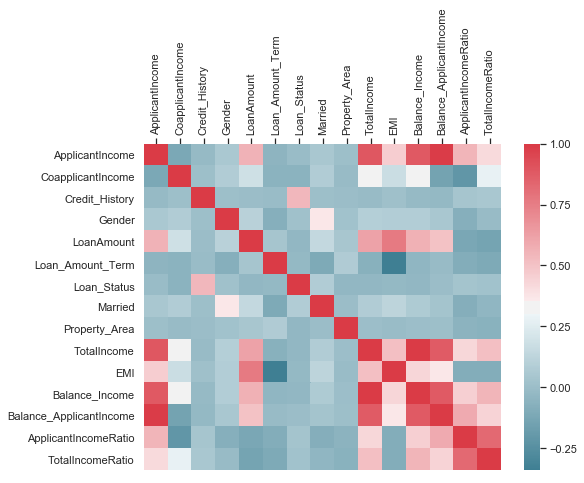

In [19]:
correlation = full_dataset[full_dataset['Loan_Status'].notnull()][full_dataset.describe(include=[np.number]).columns.values.tolist()].corr()
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(correlation, 
           xticklabels=correlation.columns.values,
           yticklabels=correlation.index.values,
           cmap=cmap)
ax.xaxis.tick_top()
plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()

In [20]:
train_Id  = full_dataset[full_dataset['Loan_Status'].notnull()]["Loan_ID"]
test_Id = full_dataset[full_dataset['Loan_Status'].isnull()]["Loan_ID"]
full_dataset.drop(['Loan_ID','CoapplicantIncome','TotalIncome', 
                   'Balance_Income','ApplicantIncome', 
                   ],axis=1,inplace=True)

full_dataset = pd.get_dummies(full_dataset, prefix_sep='_', drop_first=False)

full_dataset.drop([ 'Education_Not Graduate','Self_Employed_No' ,'HasCoApplicant_N'],axis=1,inplace=True)

from datatools.customtransformers import StdScaleTransformer,RobustScaleTransformer,MinMaxTransformer,LogTransformer
scaler = LogTransformer(['EMI','LoanAmount'])
full_dataset =scaler.fit_transform(full_dataset)

In [21]:
def evaluvate_model(clf ,X_trainmodel, y_trainmodel,X_val,y_val): 
    clf.fit(X_trainmodel, y_trainmodel.values.ravel())
    train_sizes, train_scores, validation_scores = learning_curve(clf, 
                                                                  X_trainmodel,y_trainmodel.values.ravel(),cv=kfold)
    plot_learning_curve(train_sizes, train_scores, validation_scores)
    plot_roc(X_val,y_val,clf)
    y_pred=measure_performance(X_val,y_val,clf, show_accuracy=False, 
                               show_classification_report=True,
                               show_confusion_matrix=True, show_r2_score=False)


In [22]:
train_X = full_dataset[full_dataset['Loan_Status'].notnull()] 
test_X = full_dataset[full_dataset['Loan_Status'].isnull()]  
train_y= full_dataset[full_dataset['Loan_Status'].notnull()]['Loan_Status']
train_X.drop(['Loan_Status'],axis=1,inplace=True)
test_X.drop(['Loan_Status'],axis=1,inplace=True)

In [23]:
from sklearn.model_selection import train_test_split
print(train_X.shape)
print(test_X.shape)
test_size = 0.20
seed = 42
X_trainmodel, X_val, y_trainmodel, y_val = train_test_split(train_X, train_y, test_size=test_size,random_state=seed)
kfold = StratifiedKFold(n_splits=10)

(614, 17)
(367, 17)


Accuracy: 89.817


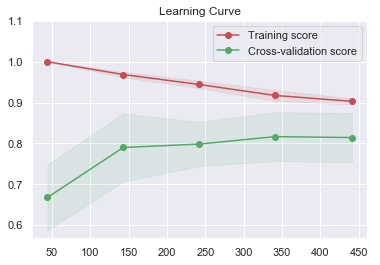

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=False, subsample=1)


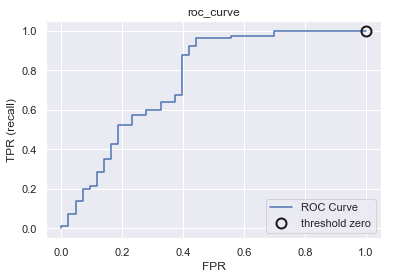

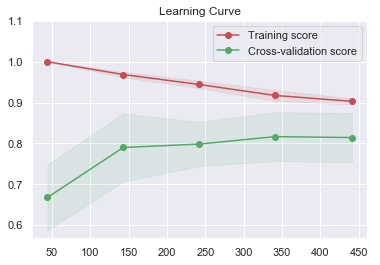

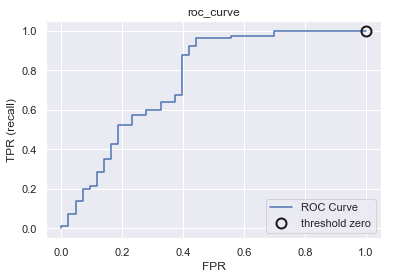

Classification report
              precision    recall  f1-score   support

         0.0       0.86      0.56      0.68        43
         1.0       0.80      0.95      0.87        80

   micro avg       0.81      0.81      0.81       123
   macro avg       0.83      0.75      0.77       123
weighted avg       0.82      0.81      0.80       123

Confusion matrix
[[24 19]
 [ 4 76]]


In [24]:
from xgboost.sklearn import XGBClassifier

xgbr = XGBClassifier(n_estimators=100, silent=False)
xgbr.fit(X_trainmodel ,y_trainmodel.values.ravel())

warnings.filterwarnings("ignore", category=DeprecationWarning) 

best_model ,result = test_classifier(xgbr,X_trainmodel,y_trainmodel,kfold)
print(best_model)
plot_roc(X_val,y_val,best_model)

warnings.filterwarnings("ignore", category=DeprecationWarning) 

evaluvate_model(xgbr,X_trainmodel, y_trainmodel,X_val,y_val)

In [25]:
def calc_accuracy(predictions, y_test):
    labels = y_test.get_label()
    return 'accuracy_score', (1 - sum(labels != predictions)/len(labels))

In [26]:
import xgboost as xgb

In [27]:
params = {"objective": "multi:softmax",
          'num_class': 2,
          "booster" : "gbtree",
          'learning_rate': 0.1,
          "max_depth": 3,
          "subsample": 1,
          'colsample_bylevel': 1,
          'gamma': 0,
          'min_child_weight': 1,
          "silent": 1,
          }

num_boost_round =60

In [28]:
print("Train a XGBoost model")
dtrain = xgb.DMatrix(X_trainmodel, y_trainmodel)
dvalid = xgb.DMatrix(X_val, y_val)

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, watchlist,
                feval=calc_accuracy, maximize=True, early_stopping_rounds=50, verbose_eval=True)

Train a XGBoost model
[0]	train-merror:0.173116	eval-merror:0.195122	train-accuracy_score:0.826884	eval-accuracy_score:0.804878
Multiple eval metrics have been passed: 'eval-accuracy_score' will be used for early stopping.

Will train until eval-accuracy_score hasn't improved in 50 rounds.
[1]	train-merror:0.173116	eval-merror:0.195122	train-accuracy_score:0.826884	eval-accuracy_score:0.804878
[2]	train-merror:0.173116	eval-merror:0.195122	train-accuracy_score:0.826884	eval-accuracy_score:0.804878
[3]	train-merror:0.169043	eval-merror:0.195122	train-accuracy_score:0.830957	eval-accuracy_score:0.804878
[4]	train-merror:0.169043	eval-merror:0.195122	train-accuracy_score:0.830957	eval-accuracy_score:0.804878
[5]	train-merror:0.169043	eval-merror:0.195122	train-accuracy_score:0.830957	eval-accuracy_score:0.804878
[6]	train-merror:0.169043	eval-merror:0.195122	train-accuracy_score:0.830957	eval-accuracy_score:0.804878
[7]	train-merror:0.169043	eval-merror:0.195122	train-accuracy_score:0.830

Text(0.5,0,'relative importance')

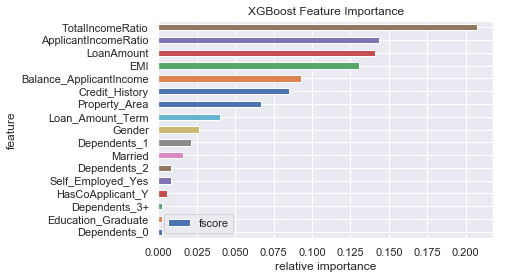

In [29]:
def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    i = 0
    for feat in features:
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
        i = i + 1
    outfile.close()

import operator
create_feature_map(X_trainmodel)

importance = gbm.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))

df_importances = pd.DataFrame(importance, columns=['feature', 'fscore'])
df_importances['fscore'] = df_importances['fscore'] / df_importances['fscore'].sum()

df_importances.plot(kind='barh', x='feature', y='fscore')
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')

In [36]:
test_y  =gbm.predict(xgb.DMatrix(test_X))

In [37]:
submission =pd.DataFrame({'Loan_ID':test_Id.values ,'Loan_Status':test_y}) 
submission['Loan_Status'].replace(0, 'N',inplace=True)
submission['Loan_Status'].replace(1, 'Y',inplace=True)
import datetime
FORMAT = '%Y%m%d%H%M%S'
timestamp=datetime.datetime.now().strftime(FORMAT)
filename ="LoanAV_XgBooost"+timestamp+"_out.csv"

In [38]:
submission.to_csv(filename)

In [33]:
heatmap_data =X_trainmodel
corr_matrix =heatmap_data.corr('pearson')
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool)) 
correlation_threshold = 0.80
to_drop = [column for column in upper.columns if any(upper[column].abs() > correlation_threshold) and column not in ['Loan_Status']]
to_drop  

['EMI']

In [34]:
correlated_predictors ={}
record_collinear = pd.DataFrame(columns = ['drop_feature', 'corr_feature', 'corr_value'])
for column in to_drop:
    co_related_features = list(upper.index[upper[column].abs() > correlation_threshold])
    co_related_values = list(upper[column][upper[column].abs() > correlation_threshold])
    drop_features = [column for _ in range(len(co_related_features))]  

    temp_df = pd.DataFrame.from_dict({'drop_feature': drop_features,
                                             'corr_feature': co_related_features,
                                             'corr_value': co_related_values})
    record_collinear = record_collinear.append(temp_df, ignore_index = True)
record_collinear.sort_values(by=['corr_value'],ascending=True)

,drop_feature,corr_feature,corr_value
0,EMI,LoanAmount,0.9149


In [35]:
Checkpoint

NameError: name 'Checkpoint' is not defined

In [39]:
params2 = {'booster':'gbtree', 
'colsample_bylevel':1,
'gamma':0.10, 
'learning_rate':0.1,
'max_delta_step':0, 
'max_depth':3, 
'min_child_weight':1, 
'missing':None,
'n_estimators':50, 
'n_jobs':1, 
'nthread':4, 
'objective': 'multi:softmax',
'num_class': 2,
'random_state':0, 
'reg_alpha':0.01, 
'reg_lambda':0.6, 
'scale_pos_weight':1,
'silent':True,
'subsample':0.85
          }

num_boost_round =60

print("Train a XGBoost model")
dtrain = xgb.DMatrix(X_trainmodel, y_trainmodel)
dvalid = xgb.DMatrix(X_val, y_val)

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params2, dtrain, num_boost_round, watchlist, feval=calc_accuracy, maximize=True, early_stopping_rounds=50, verbose_eval=True)

Train a XGBoost model
[0]	train-merror:0.167006	eval-merror:0.219512	train-accuracy_score:0.832994	eval-accuracy_score:0.780488
Multiple eval metrics have been passed: 'eval-accuracy_score' will be used for early stopping.

Will train until eval-accuracy_score hasn't improved in 50 rounds.
[1]	train-merror:0.167006	eval-merror:0.186992	train-accuracy_score:0.832994	eval-accuracy_score:0.813008
[2]	train-merror:0.167006	eval-merror:0.186992	train-accuracy_score:0.832994	eval-accuracy_score:0.813008
[3]	train-merror:0.169043	eval-merror:0.186992	train-accuracy_score:0.830957	eval-accuracy_score:0.813008
[4]	train-merror:0.169043	eval-merror:0.186992	train-accuracy_score:0.830957	eval-accuracy_score:0.813008
[5]	train-merror:0.164969	eval-merror:0.186992	train-accuracy_score:0.835031	eval-accuracy_score:0.813008
[6]	train-merror:0.164969	eval-merror:0.186992	train-accuracy_score:0.835031	eval-accuracy_score:0.813008
[7]	train-merror:0.164969	eval-merror:0.186992	train-accuracy_score:0.835

Accuracy: 87.576


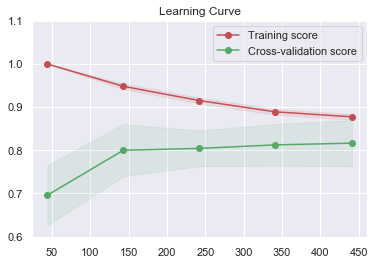

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.1, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=50,
       n_jobs=1, nthread=4, num_class=2, objective='multi:softmax',
       random_state=0, reg_alpha=0.01, reg_lambda=0.6, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.85)


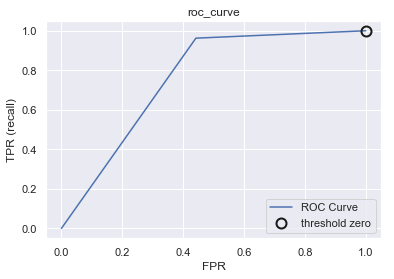

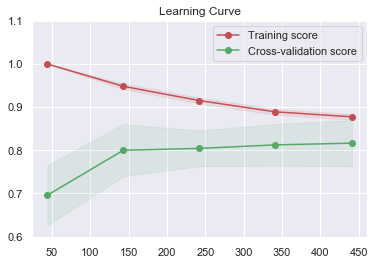

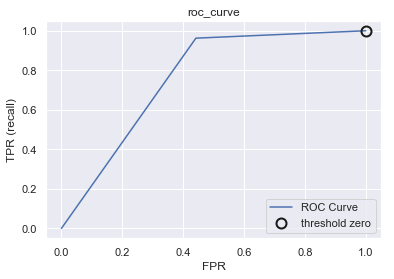

Classification report
              precision    recall  f1-score   support

         0.0       0.89      0.56      0.69        43
         1.0       0.80      0.96      0.88        80

   micro avg       0.82      0.82      0.82       123
   macro avg       0.85      0.76      0.78       123
weighted avg       0.83      0.82      0.81       123

Confusion matrix
[[24 19]
 [ 3 77]]


In [40]:
xgclf = XGBClassifier(**params2)
xgclf.fit(X_trainmodel ,y_trainmodel.values.ravel())

warnings.filterwarnings("ignore", category=DeprecationWarning) 

best_model ,result = test_classifier(xgclf,X_trainmodel,y_trainmodel,kfold)
print(best_model)
plot_roc(X_val,y_val,best_model)

warnings.filterwarnings("ignore", category=DeprecationWarning) 

evaluvate_model(xgclf,X_trainmodel, y_trainmodel,X_val,y_val)

In [41]:
test_y_xgBoost  =xgclf.predict(test_X)

Accuracy: 87.576


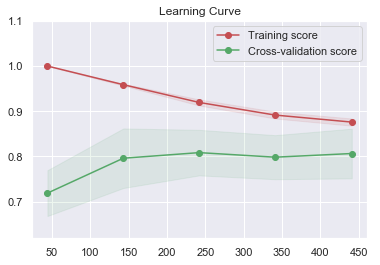

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.15, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=4,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=2, min_samples_split=3,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              n_iter_no_change=None, presort='auto', random_state=2,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)
Classification report
              precision    recall  f1-score   support

         0.0       0.86      0.56      0.68        43
         1.0       0.80      0.95      0.87        80

   micro avg       0.81      0.81      0.81       123
   macro avg       0.83      0.75      0.77       123
weighted avg       0.82      0.81      0.80       123

Confusion matrix
[[24 19]
 [ 4 76]]


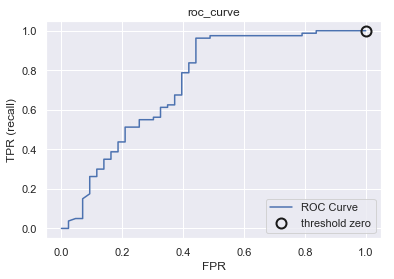

In [42]:
from sklearn.ensemble import GradientBoostingClassifier
original_params = {'n_estimators':50, 'max_leaf_nodes':4, 'max_depth': 3, 'random_state': 2,
                   'min_samples_split':3,'min_samples_leaf':2,'learning_rate':0.15 }

gbc =GradientBoostingClassifier(**original_params)
gbc.fit(X_trainmodel, y_trainmodel.values.ravel())
 
best_gc =  gbc
best_gc ,result = test_classifier(best_gc,X_trainmodel,y_trainmodel,kfold)
print(best_gc)

y_pred=measure_performance(X_val,y_val,best_gc, show_accuracy=False, 
                    show_classification_report=True,
                    show_confusion_matrix=True, show_r2_score=False)

plot_roc(X_val,y_val,best_gc)

Accuracy: 78.862
Accuracy: 81.466


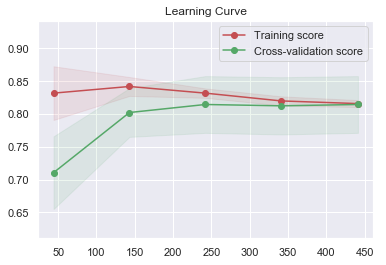

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
Best Penalty: l1
Best C: 1.0
Accuracy: 81.466


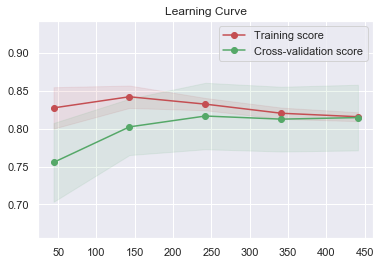

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': array([ 1.     ,  1.29155,  1.6681 ,  2.15443,  2.78256,  3.59381,
        4.64159,  5.99484,  7.74264, 10.     ]), 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)
Classification report
              precision    recall  f1-score   support

         0.0       0.95      0.42      0.58        43
         1.0       0.76      0.99      0.86        80

   micro avg       0.79      0.79      0.79       123
   macro avg       0.85      0.70      0.72       123
weighted avg       0.83      0.79      0.76     

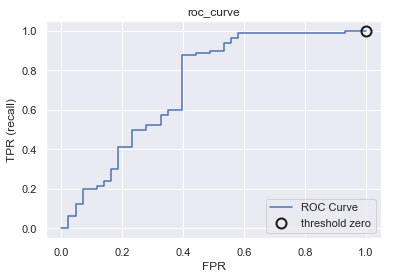

In [43]:
from sklearn.linear_model import LogisticRegression
logrmodel = LogisticRegression()
logrmodel.fit(X_trainmodel, y_trainmodel.values.ravel())
result = logrmodel.score(X_val, y_val)
print ("Accuracy: {0:.3f}".format(result*100.0))
logrmodel ,result = test_classifier(logrmodel,X_trainmodel,y_trainmodel,kfold)
print(logrmodel)

# Create regularization penalty space
penalty = ['l1', 'l2']
# Create regularization hyperparameter space
C = np.logspace(0, 1, 10)
# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)
warnings.filterwarnings("ignore", category=DeprecationWarning) 
clf = GridSearchCV(logrmodel, hyperparameters, cv=5, verbose=0,scoring='accuracy')
best_model = clf.fit(X_trainmodel, y_trainmodel.values.ravel())
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

best_lr_model ,result = test_classifier(best_model,X_trainmodel,y_trainmodel,kfold)
print(best_lr_model)

y_pred=measure_performance(X_val,y_val,best_lr_model, show_accuracy=False, 
                    show_classification_report=True,
                    show_confusion_matrix=True, show_r2_score=False)

plot_roc(X_val,y_val,best_lr_model)

In [44]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:    7.7s finished


AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=3,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1e-05, n_estimators=40, random_state=7)


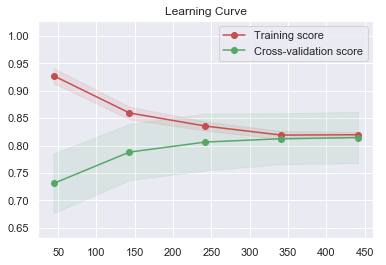

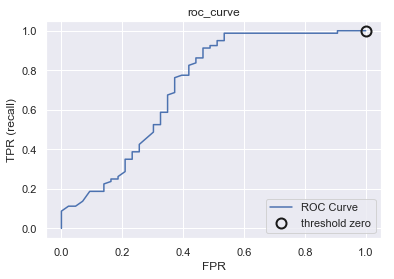

Classification report
              precision    recall  f1-score   support

         0.0       0.95      0.42      0.58        43
         1.0       0.76      0.99      0.86        80

   micro avg       0.79      0.79      0.79       123
   macro avg       0.85      0.70      0.72       123
weighted avg       0.83      0.79      0.76       123

Confusion matrix
[[18 25]
 [ 1 79]]


In [45]:
dtc = DecisionTreeClassifier( class_weight=None, criterion='gini',
            max_depth=3, max_features='sqrt',
            max_leaf_nodes=None,min_samples_leaf=1,
            min_samples_split=3
            )
ada_dtc = AdaBoostClassifier(dtc, random_state=7)
ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", ],
              "algorithm" : ["SAMME"],
              "n_estimators" :[40],
              "learning_rate":  [0.00001, 0.0001]}

gsada_dtc = GridSearchCV(ada_dtc,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsada_dtc.fit(X_trainmodel, y_trainmodel.values.ravel())

ada_best = gsada_dtc.best_estimator_
print(ada_best)
evaluvate_model(ada_best,X_trainmodel, y_trainmodel,X_val,y_val)

In [46]:
parameter_grid = {
                 'max_depth' : [3, 6, 8],
                 'n_estimators': [50, 100],
                 'max_features': ['sqrt',],
                 "min_samples_split": [2,3,10],
                 "min_samples_leaf": [1,3,10],
                 "criterion": ["gini"],
                  #"oob_score":[True]
                  #"class_weight":[{0: 0.61616, 1: 0.38384}]
                 }

rfcg =RandomForestClassifier()
grid_search = GridSearchCV(rfcg,param_grid = parameter_grid,verbose = 1,n_jobs =-1,cv=kfold,)

grid_search.fit(X_trainmodel ,y_trainmodel.values.ravel())

rfc_best = grid_search.best_estimator_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   43.9s
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:   53.9s finished


Accuracy: 84.114


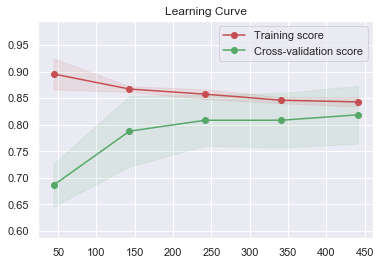

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [47]:
rfc_best.fit(X_trainmodel, y_trainmodel.values.ravel())
rfc_best_model ,result = test_classifier(rfc_best,X_trainmodel,y_trainmodel,kfold)
print(rfc_best_model)

In [48]:
from mlxtend.classifier import StackingClassifier

Accuracy: 88.595


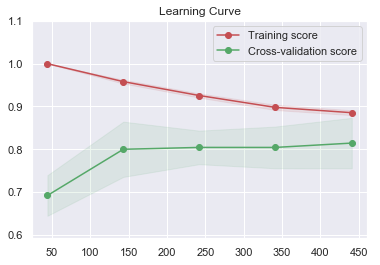

StackingClassifier(average_probas=False,
          classifiers=[GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.15, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=4,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=2, min_samp... reg_alpha=0.01, reg_lambda=0.6, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.85)],
          meta_classifier=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          store_train_meta_features=False, use_clones=True,
          use_features_in_secondary=

In [49]:
sclf = StackingClassifier(classifiers=[best_gc ,xgclf], 
                          meta_classifier= rfc_best_model )
sclf.fit(X_trainmodel,y_trainmodel)
best_sclf_model ,result = test_classifier(sclf,X_trainmodel,y_trainmodel,kfold)
print(best_sclf_model)

Accuracy: 88.595


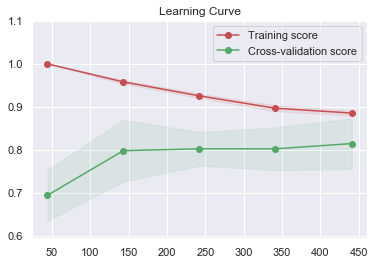

EnsembleVoteClassifier(clfs=[StackingClassifier(average_probas=False,
          classifiers=[GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.15, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=4,
              min_impurity_decrease=0.0, min_impuri... reg_alpha=0.01, reg_lambda=0.6, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.85)],
            refit=True, verbose=0, voting='hard', weights=[3, 2, 1, 4])


In [50]:
from mlxtend.classifier import EnsembleVoteClassifier
eclf = EnsembleVoteClassifier(clfs=[sclf, best_gc ,rfc_best_model,xgclf], weights=[3,2,1,4])
eclf.fit(X_trainmodel,y_trainmodel)
best_eclf_model ,result = test_classifier(eclf,X_trainmodel,y_trainmodel,kfold)
print(best_eclf_model)

In [51]:
test_y =best_eclf_model.predict(test_X)

In [52]:
submission =pd.DataFrame({'Loan_ID':test_Id.values ,'Loan_Status':test_y}) 
submission['Loan_Status'].replace(0, 'N',inplace=True)
submission['Loan_Status'].replace(1, 'Y',inplace=True)
import datetime
FORMAT = '%Y%m%d%H%M%S'
timestamp=datetime.datetime.now().strftime(FORMAT)
filename ="Ensemble_Voting"+timestamp+"_out.csv"

submission.to_csv(filename)